# Spanning tree modulus

In [59]:
%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import cvxpy as cvx
from itertools import combinations
import random

from modulus_tools.basic_algorithm import matrix_modulus, modulus
from modulus_tools.families.networkx_families import MinimumSpanningTree
from modulus_tools import algorithms as alg

## Computing spanning-tree modulus

Spanning trees form one of the most important families of objects in a graph.  

This notebook provides examples of computing the **modulus** of spanning trees in two ways:  
1. directly via a convex program, and  
2. using the **Basic Algorithm**.  

For the precise **definition of modulus**, see the [nathan-albin.github.io/modulus_book/Introduction](https://nathan-albin.github.io/modulus_book/Introduction.html) in the online modulus book.  
For details on the **Basic Algorithm**, see [nathan-albin.github.io/modulus_book/The_Basic_Algorithm](https://nathan-albin.github.io/modulus_book/The_Basic_Algorithm.html).


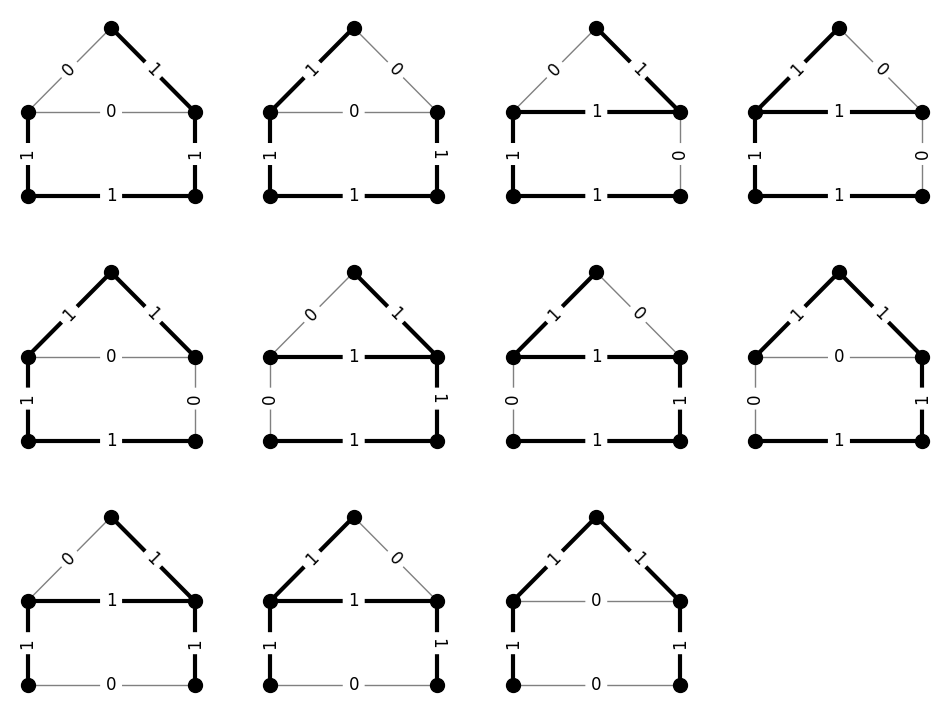

In [60]:
# 1) Build the "house" graph
G = nx.Graph()
G.add_edges_from([
    (0, 1), (1, 2), (2, 3), (3, 0)  # square
])
G.add_edge(2, 4)
G.add_edge(3, 4)
pos = {
    0: (-1, 0), 
    1: ( 1, 0),   
    2: ( 1, 1),   
    3: (-1, 1),   
    4: ( 0, 2),   
}
# get a list of spanning trees
trees = list(alg.spanning_trees(G))

# number of columns and rows for plot
ncol = 4
nrow = int(np.ceil(len(trees)/ncol))

# draw the trees
plt.figure(figsize=(3*ncol,3*nrow))
for i,tree in enumerate(trees):
    plt.subplot(nrow,ncol,i+1)
    labels = {(u,v):0 for u,v in G.edges}
    labels.update({(u,v):1 for u,v in tree})
    edges = tree
    nx.draw(G, pos, node_size=100, node_color='black', edge_color='gray')
    nx.draw_networkx_edges(G, pos, edgelist=edges, width=3)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=12)

### Compute spanning tree modulus using CVXPy

In [61]:
def matrix(G):
    """
    Build the usage matrix N for the family of spanning trees of G.

    Each row of N corresponds to a spanning tree (n-1 edges).
    Each column corresponds to one edge of G.
    Entry = 1 if that spanning tree uses the edge, 0 otherwise.

    """
    # Assign an index to each edge and store in G[u][v]['enum']
    for i, (u, v) in enumerate(G.edges()):
        G[u][v]['enum'] = i

    n = len(G.nodes)   # number of nodes
    N = []             # will collect the rows of the usage matrix

    # Loop through all (n-1)-edge subsets of G
    for T in combinations(G.edges, n-1):
        H = nx.Graph(T)         # build subgraph with these edges
        if nx.is_tree(H):       # check if it is a spanning tree
            v = np.zeros(m)     # indicator vector for edges
            for (a, b) in T:
                ind = G[a][b]['enum']  # column index of edge (a,b)
                v[ind] = 1
            N.append(v)

    # Return as a numpy array
    return np.array(N)


In [62]:
def modul(N, p, sigma):
    """
    Compute the p-modulus of a family (with usage matrix N) via convex optimization.
    """

    # number of variables (edges in the graph)
    n = N.shape[-1]

    # make sigma into a diagonal matrix
    S = np.diag(sigma)

    # optimization variable: edge density vector rho
    rho = cvx.Variable(n)

    # apply scaling S^(1/p) to rho
    X = (S**(1./p)) @ rho

    # objective: minimize ||X||_p^p
    obj = cvx.Minimize(cvx.pnorm(X, p) ** p)

    # constraints:
    #   1. rho >= 0 (nonnegative densities)
    #   2. N @ rho >= 1 (admissibility condition)
    cons = [rho >= 0, N @ rho >= 1]

    # solve the convex program
    prob = cvx.Problem(obj, cons)
    prob.solve(solver=cvx.SCS)

    # return optimal value and vector (as numpy arrays)
    return np.array(obj.value).flatten(), np.array(rho.value).flatten()


Modulus (p=2): 0.37499916426700797
η* = [0.667 0.667 0.667 0.667 0.667 0.667]


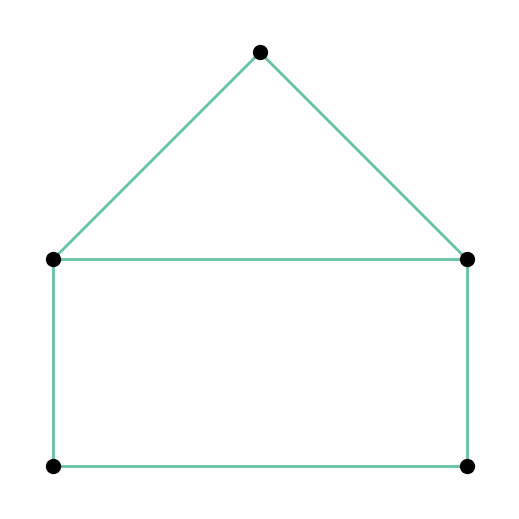

In [63]:
# 1) Build the "house" graph
G = nx.Graph()

# Square base: nodes 0-1-2-3
G.add_edges_from([
    (0, 1), (1, 2), (2, 3), (3, 0)  # square
])


# Roof apex node (4), connected to the top two square vertices
G.add_edge(2, 4)
G.add_edge(3, 4)

# 2) Improved "house" layout
pos = {
    0: (-1, 0),   # bottom-left
    1: ( 1, 0),   # bottom-right
    2: ( 1, 1),   # top-right
    3: (-1, 1),   # top-left
    4: ( 0, 2),   # roof apex centered above the square
}

# 3) Compute spanning-tree modulus (p = 2 example)
m = len(G.edges())
N = matrix(G)                  # your spanning-tree usage matrix function
mod, rho = modul(N, 2, np.ones(m))

# 4) Plot η* = rho / mod as edge colors
eta = np.round(rho / mod, 3)
print("Modulus (p=2):", mod.item())
print("η* =", eta)

plt.figure(figsize=(5,5))
nx.draw(
    G, pos,
    node_size=100, node_color='black',
    width=2, edge_color=eta, edge_cmap=plt.cm.Set2
)
plt.axis("equal")
plt.show()


### Compute the spanning tree modulus using the Basic Algorithm

In [64]:
def mod_basic(G):
    """
    Compute and visualize the spanning-tree modulus of a graph G using the Basic Algorithm.
    """

    # Number of edges (m) passed to the Basic Algorithm
    m = len(G.edges())

    # Shortest-object oracle for the spanning-tree family
    mst = MinimumSpanningTree(G)

    # Run the Basic Algorithm (keep the same call/signature as in your code)
    mod, cons, rho, lam = modulus(m, matrix_modulus, mst, max_iter=400)

    # Return the density vector and modulus value
    return rho, mod


Modulus (p=2): 0.21428571428571433
η* = [0.333 0.333 0.333 0.333 0.333 0.5   0.333 0.333 0.333 0.333 0.5   0.333
 0.333 0.333 0.5   0.333 0.333 0.5   0.333 0.5   0.5   0.5   0.5   0.5
 0.5   0.5   0.5  ]


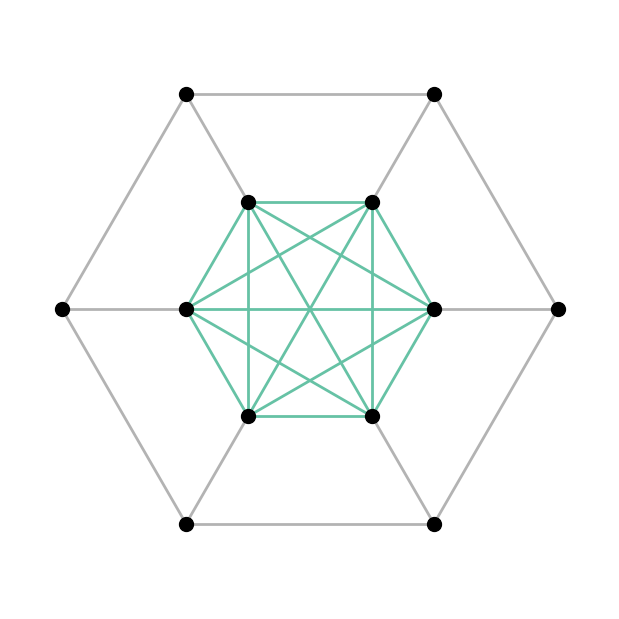

In [65]:

# Build a graph
P = nx.complete_graph(6)              # nodes 0..5
for u in range(6):
    P.add_edge(u, u + 6)              # rungs
nx.add_path(P, [6, 7, 8, 9, 10, 11, 6])  # outer ring

# Compute modulus using your basic algorithm wrapper
rho, mod = mod_basic(P)

# Ensure scalar modulus and compute η* = rho / mod
mod_val = mod.item()
eta = np.round(rho / mod_val, 3)
print("Modulus (p=2):", mod_val)
print("η* =", eta)

# Two-ring layout: nodes 0..5 inner circle, nodes 6..11 outer circle
pos = {}
inner_pos = nx.circular_layout(range(6), scale=0.6)     # inner K6
outer_pos = nx.circular_layout(range(6, 12), scale=1.2) # outer 6-cycle
pos.update(inner_pos)
pos.update(outer_pos)

# Plot η* as edge colors
plt.figure(figsize=(6, 6))
nx.draw(
    P, pos,
    node_size=100, node_color='black',
    width=2, edge_color=eta, edge_cmap=plt.cm.Set2
)
plt.axis("equal")
plt.show()
